## Extracting


In [ ]:
# Download dataset
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2025-11-30 09:47:10--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2025-11-30 09:47:11--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G   155MB/s    in 26s     

2025-11-30 09:47:37 (182 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
!tar -xf food-101.tar.gz

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import shutil
import tensorflow.keras

## EDA

In [ ]:
DATA_DIR = "/content/food-101/images"

In [ ]:
categories = os.listdir(DATA_DIR)
categories = [dir_ for dir_ in categories if dir_ !=".DS_Store"]
print(f"There are {len(categories)} categories of food")

There are 101 categories of food


In [ ]:
def plot_random_image(category, axis = False, ax=None):
    directory = os.path.join(DATA_DIR, category)
    images = glob.glob(f"{directory}/*")
    random_int = np.random.randint(0, len(images)-1)
    random_image = images[random_int]
    img = plt.imread(random_image)
    ax.imshow(img)
    ax.set_title(category)
    ax.axis(axis)

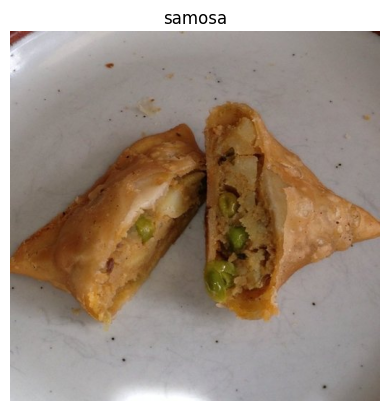

In [ ]:
plot_random_image("samosa", ax = plt.gca())

In [ ]:
row = 10
col = 10
fig, axes = plt.subplots(row, col, figsize = (20, 20))
axes = axes.flatten()
for i, ax in enumerate(axes):
    print(f"Adding Image: {(i+1):>3d}/{row*col:>3d}", end = "\r")
    random_food = np.random.choice(categories)
    plot_random_image(random_food, ax = ax)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for food in categories:
    print(f"There are {len(os.listdir(os.path.join(DATA_DIR, food)))} images in {food}")

There are 1000 images in fish_and_chips
There are 1000 images in beef_tartare
There are 1000 images in eggs_benedict
There are 1000 images in beet_salad
There are 1000 images in panna_cotta
There are 1000 images in sushi
There are 1000 images in waffles
There are 1000 images in pho
There are 1000 images in prime_rib
There are 1000 images in paella
There are 1000 images in spaghetti_bolognese
There are 1000 images in baklava
There are 1000 images in french_toast
There are 1000 images in greek_salad
There are 1000 images in beef_carpaccio
There are 1000 images in chicken_curry
There are 1000 images in foie_gras
There are 1000 images in tiramisu
There are 1000 images in donuts
There are 1000 images in strawberry_shortcake
There are 1000 images in french_fries
There are 1000 images in ravioli
There are 1000 images in ice_cream
There are 1000 images in chicken_wings
There are 1000 images in cheese_plate
There are 1000 images in takoyaki
There are 1000 images in ramen
There are 1000 images i

So, there are 1000 images for each category. We'll use 50 images per category which makes 50×101=5050 images. This should be more than enough for evaluation.

Let's create some directories:

In [ ]:
os.chdir("food-101")
os.mkdir("train")
os.mkdir("validation")
os.chdir("..")
os.listdir("food-101")

['meta',
 'README.txt',
 'images',
 'validation',
 'train',
 'license_agreement.txt']

In [ ]:
def copy_one(food):
    directory = os.path.join(DATA_DIR, food)
    images = glob.glob(f"{directory}/*")
    val_images = 50
    val_image_indices = np.random.choice(len(images), 50, replace=False)
    train_dir = os.path.join("food-101", "train", food)
    val_dir = os.path.join("food-101", "validation", food)
    if os.path.exists(train_dir):
        print("Directory Exist")
        return None
    if os.path.exists(val_dir):
        print("Directory Exist")
        return None
    os.mkdir(train_dir)
    os.mkdir(val_dir)
    for i, img in enumerate(images):
        image_name = images[i].split(os.path.sep)[-1]
        if i in val_image_indices:
            shutil.copy(images[i], os.path.join(val_dir, image_name))
        else:
            shutil.copy(images[i], os.path.join(train_dir, image_name))

In [ ]:
for food in tqdm(categories, desc="Copying..."):
    copy_one(food)

Copying...: 100%|██████████| 101/101 [00:13<00:00,  7.57it/s]


## meta

In [ ]:
os.listdir('/content/food-101/meta')

['classes.txt',
 'labels.txt',
 'test.json',
 'train.json',
 'train.txt',
 'test.txt']

In [ ]:
DATA_DIR

'/content/food-101/images'

In [ ]:
!head 'food-101/meta/train.txt'

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [ ]:
train_df = pd.read_csv('/content/food-101/meta/train.txt', header = None, names=['path'])
train_df.head()

,path
0,apple_pie/1005649
1,apple_pie/1014775
2,apple_pie/1026328
3,apple_pie/1028787
4,apple_pie/1043283


In [ ]:
test_df = pd.read_csv('/content/food-101/meta/test.txt', header = None, names=['path'])
test_df.head()

,path
0,apple_pie/1011328
1,apple_pie/101251
2,apple_pie/1034399
3,apple_pie/103801
4,apple_pie/1038694


In [ ]:
def spliter(data, class_or_id='id'):
    if class_or_id.upper() == 'CLASS':
        output = data.split('/')[0]

    else:
        output = data.split('/')[-1]
    return output

In [ ]:
train_df['label'] = train_df['path'].map(lambda x: spliter(data = x, class_or_id = 'Class'))
train_df.head()

,path,label
0,apple_pie/1005649,apple_pie
1,apple_pie/1014775,apple_pie
2,apple_pie/1026328,apple_pie
3,apple_pie/1028787,apple_pie
4,apple_pie/1043283,apple_pie


In [ ]:
train_df['idx'] = train_df['path'].map(lambda x: spliter(x))
train_df.head()

,path,label,idx
0,apple_pie/1005649,apple_pie,1005649
1,apple_pie/1014775,apple_pie,1014775
2,apple_pie/1026328,apple_pie,1026328
3,apple_pie/1028787,apple_pie,1028787
4,apple_pie/1043283,apple_pie,1043283


In [ ]:
test_df['label'] = test_df['path'].map(lambda x: spliter(x, 'class'))
test_df['idx'] = test_df['path'].map(lambda x: spliter(x))
test_df.head()

,path,label,idx
0,apple_pie/1011328,apple_pie,1011328
1,apple_pie/101251,apple_pie,101251
2,apple_pie/1034399,apple_pie,1034399
3,apple_pie/103801,apple_pie,103801
4,apple_pie/1038694,apple_pie,1038694


In [ ]:
train_df['label'].unique()

array(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio',
       'beef_tartare', 'beet_salad', 'beignets', 'bibimbap',
       'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad',
       'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake',
       'cheese_plate', 'chicken_curry', 'chicken_quesadilla',
       'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros',
       'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee',
       'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts',
       'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel',
       'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries',
       'french_onion_soup', 'french_toast', 'fried_calamari',
       'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi',
       'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon',
       'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog',
       'huevos_rancheros', 'hummus', 'ice_cr

In [ ]:
len(train_df['label'].unique())

101

In [ ]:
mini_101 = train_df['label'].unique()
mini_101 = [f.upper() for f in mini_101]
mini_101

['APPLE_PIE',
 'BABY_BACK_RIBS',
 'BAKLAVA',
 'BEEF_CARPACCIO',
 'BEEF_TARTARE',
 'BEET_SALAD',
 'BEIGNETS',
 'BIBIMBAP',
 'BREAD_PUDDING',
 'BREAKFAST_BURRITO',
 'BRUSCHETTA',
 'CAESAR_SALAD',
 'CANNOLI',
 'CAPRESE_SALAD',
 'CARROT_CAKE',
 'CEVICHE',
 'CHEESECAKE',
 'CHEESE_PLATE',
 'CHICKEN_CURRY',
 'CHICKEN_QUESADILLA',
 'CHICKEN_WINGS',
 'CHOCOLATE_CAKE',
 'CHOCOLATE_MOUSSE',
 'CHURROS',
 'CLAM_CHOWDER',
 'CLUB_SANDWICH',
 'CRAB_CAKES',
 'CREME_BRULEE',
 'CROQUE_MADAME',
 'CUP_CAKES',
 'DEVILED_EGGS',
 'DONUTS',
 'DUMPLINGS',
 'EDAMAME',
 'EGGS_BENEDICT',
 'ESCARGOTS',
 'FALAFEL',
 'FILET_MIGNON',
 'FISH_AND_CHIPS',
 'FOIE_GRAS',
 'FRENCH_FRIES',
 'FRENCH_ONION_SOUP',
 'FRENCH_TOAST',
 'FRIED_CALAMARI',
 'FRIED_RICE',
 'FROZEN_YOGURT',
 'GARLIC_BREAD',
 'GNOCCHI',
 'GREEK_SALAD',
 'GRILLED_CHEESE_SANDWICH',
 'GRILLED_SALMON',
 'GUACAMOLE',
 'GYOZA',
 'HAMBURGER',
 'HOT_AND_SOUR_SOUP',
 'HOT_DOG',
 'HUEVOS_RANCHEROS',
 'HUMMUS',
 'ICE_CREAM',
 'LASAGNA',
 'LOBSTER_BISQUE',
 'LOBSTER

In [ ]:
def prepare_data(label):
    if label.upper() in mini_101:
        return label
    else:
        return 'Others'

In [ ]:
train_df['label'] = train_df['label'].map(lambda x: prepare_data(x))
test_df['label'] = test_df['label'].map(lambda x: prepare_data(x))

In [ ]:
train_df['label'].unique()

array(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio',
       'beef_tartare', 'beet_salad', 'beignets', 'bibimbap',
       'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad',
       'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake',
       'cheese_plate', 'chicken_curry', 'chicken_quesadilla',
       'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros',
       'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee',
       'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts',
       'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel',
       'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries',
       'french_onion_soup', 'french_toast', 'fried_calamari',
       'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi',
       'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon',
       'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog',
       'huevos_rancheros', 'hummus', 'ice_cr

In [ ]:
def add_exact_path(path):
    return '/content/food-101/images/'+path+'.jpg'

In [ ]:
train_df['path'] = train_df[['path']].apply(add_exact_path, axis=1)
test_df['path'] = test_df[['path']].apply(add_exact_path, axis=1)
train_df.head()

,path,label,idx
0,/content/food-101/images/apple_pie/1005649.jpg,apple_pie,1005649
1,/content/food-101/images/apple_pie/1014775.jpg,apple_pie,1014775
2,/content/food-101/images/apple_pie/1026328.jpg,apple_pie,1026328
3,/content/food-101/images/apple_pie/1028787.jpg,apple_pie,1028787
4,/content/food-101/images/apple_pie/1043283.jpg,apple_pie,1043283


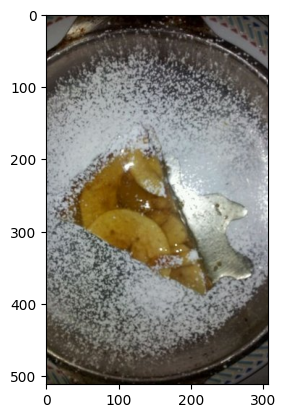

In [ ]:
from matplotlib import pyplot as plt
img = plt.imread(train_df['path'].iloc[0])
plt.imshow(img)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = datagen.flow_from_dataframe(dataframe = train_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb',
    classes=None, class_mode='categorical', batch_size=100, shuffle=True)

Found 75750 validated image filenames belonging to 101 classes.


In [ ]:
test_gen = test_gen.flow_from_dataframe(dataframe = test_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb',
    classes=None, class_mode='categorical', batch_size=32, shuffle=True)

Found 25250 validated image filenames belonging to 101 classes.


# Xceeption

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.xception import Xception

Xception = Xception(weights='imagenet', include_top=False)
x = Xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='sigmoid')(x)
# x = Dropout(0.4)(x)
x = Dense(128,activation='sigmoid')(x)
x = Dropout(0.2)(x)

predictions = Dense(101, activation='sigmoid')(x)

model = Model(inputs=Xception.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Pretraining the model with 0.001 learning rate.

In [ ]:
history = model.fit(train_gen,
                              steps_per_epoch = len(train_gen) // 32,
                    epochs=60,
                    verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.0214 - loss: 4.6987
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.0799 - loss: 4.4520
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.1639 - loss: 4.2218
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2056 - loss: 4.0001
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2118 - loss: 3.8420
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2711 - loss: 3.6110
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2867 - loss: 3.4263
Epoch 8/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3305 - loss: 3.2261
Epoch 9/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3247 - loss: 3.1562
Epoch 10/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3590 - loss: 3.0340
Epoch 11/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3743 - loss: 2.8211
Epoch 12/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3970 - l

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5932 - loss: 1.7671
Epoch 35/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6010 - loss: 1.6300
Epoch 36/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6150 - loss: 1.6558
Epoch 37/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6058 - loss: 1.6256
Epoch 38/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6204 - loss: 1.5928
Epoch 39/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6278 - loss: 1.5734
Epoch 40/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6328 - loss: 1.5029
Epoch 41/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6490 - loss: 1.4574
Epoch 42/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6444 - loss: 1.4828
Epoch 43/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6262 - loss: 1.5424
Epoch 44/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6135 - loss: 1.5816
Epoch 45/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6435 - loss:

In [ ]:
os.mkdir('/content/models')

In [ ]:
model.save('/content/models/food101.keras')

Retraining the model with 0.0001 learning rate.

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# load model from the path it was saved to
model = load_model('/content/models/food101.keras')

# Compile with run_eagerly=True to fix the numpy() error
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

# continue training the model
history0 = model.fit(train_gen,
                              steps_per_epoch = len(train_gen) // 16,
                    epochs=60,
                    verbose=1)

Epoch 1/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7129 - loss: 1.2175
Epoch 2/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7316 - loss: 1.1054
Epoch 3/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7449 - loss: 1.0686
Epoch 4/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7266 - loss: 1.1035
Epoch 5/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7556 - loss: 1.0264
Epoch 6/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7659 - loss: 0.9789
Epoch 7/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7645 - loss: 0.9833
Epoch 8/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7471 - loss: 1.0309
Epoch 9/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7768 - loss: 0.9376
Epoch 10/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7742 - loss: 0.9245
Epoch 11/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7735 - loss: 0.9325
Epoch 12/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7881 - lo

In [ ]:
model.save('/content/models/food101.keras')

In [ ]:
model = load_model('/content/models/food101.keras')
result = model.evaluate(test_gen, batch_size=32)
print(result)

790/790 ━━━━━━━━━━━━━━━━━━━━ 129s 163ms/step - accuracy: 0.8055 - loss: 0.7425
[0.7338175177574158, 0.8090693354606628]


# Testing the model

In [1]:
from google.colab import drive
from tensorflow.keras.models import load_model
import os

# Mount Google Drive
drive.mount('/content/drive')

# Load the model from Google Drive
# Using the path where it was previously saved
model_path = '/content/drive/My Drive/Computer Vision for Food Captioning/food101.keras'

if os.path.exists(model_path):
    print(f"Loading model from {model_path}...")
    model = load_model(model_path)
    print("Model loaded successfully!")
else:
    print(f"File not found at {model_path}. Please check the file path.")

Mounted at /content/drive
Loading model from /content/drive/My Drive/Computer Vision for Food Captioning/food101.keras...
Model loaded successfully!


Upload an image to classify:


Saving meatlovers.jpg to meatlovers.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


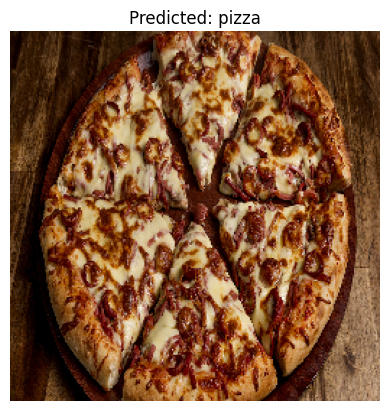

In [4]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the class names manually to make this cell independent
class_names = [
    'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad',
    'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad',
    'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake',
    'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse',
    'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame',
    'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots',
    'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup',
    'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi',
    'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger',
    'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna',
    'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup',
    'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes',
    'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib',
    'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi',
    'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara',
    'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu',
    'tuna_tartare', 'waffles'
]

# Ensure the list is sorted alphabetically, as ImageDataGenerator does by default
class_names = sorted(class_names)

# Create a mapping from index to class label
labels = {i: name for i, name in enumerate(class_names)}

print("Upload an image to classify:")
uploaded = files.upload()

for fn in uploaded.keys():
    # Load the image
    path = fn
    # Target size must match the training input size (256x256)
    img = image.load_img(path, target_size=(256, 256))

    # Preprocess the image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Rescale as done in training

    # Predict
    classes = model.predict(x, batch_size=1)
    predicted_class_idx = np.argmax(classes, axis=1)[0]
    predicted_label = labels[predicted_class_idx]

    # Display results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()